In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/cocktail_NeurIPS/feature_importance')

In [3]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np

In [4]:
menu = pd.read_csv('/content/drive/MyDrive/cocktail_dmlr/Data/menu_cleaned.csv')

In [5]:
from sklearn.model_selection import train_test_split

# Use dg_rating as target
X = menu.drop(columns=['name', 'dd_rating', 'dg_rating'], errors='ignore')
y_regression = menu.loc[X.index, 'dg_rating']

# Single split for all modeling types
X_train, X_test, y_reg_train, y_reg_test = train_test_split(
    X, y_regression, test_size=0.2, random_state=42
)

# Classification targets (as strings)
y_clf_train = y_reg_train.astype(str)
y_clf_test = y_reg_test.astype(str)



# SHAP for RF Regressor

In [6]:
# Replace with best_params from your tuned model
rf_best_params = {
    'n_estimators': 200,
    'max_depth': None,
    'min_samples_split': 2,
    'max_features': 'sqrt'
}

rf_model = RandomForestRegressor(random_state=42, **rf_best_params)
rf_model.fit(X_train, y_reg_train)

RandomForestRegressor(max_features='sqrt', n_estimators=200, random_state=42)

In [7]:
# Compute SHAP values on the test subset
explainer = shap.Explainer(rf_model, X_test)
shap_values = explainer(X_test)

# Compute mean absolute SHAP values per feature
shap_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': shap_values.abs.mean(0).values
}).sort_values(by='importance', ascending=False)

100%|===================| 1276/1281 [03:42<00:00]       

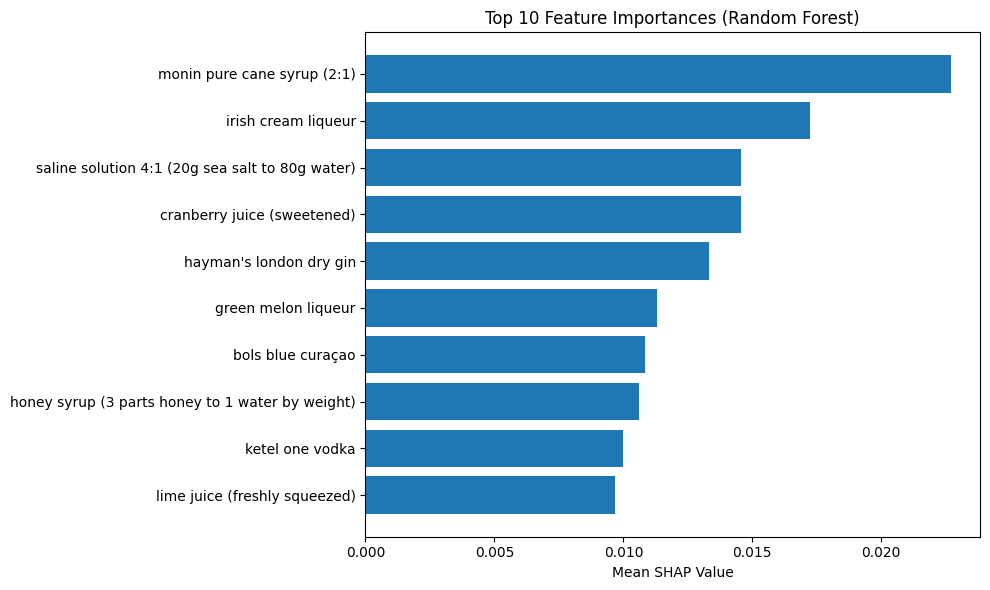

In [8]:
# Plot top 10 features
top_10 = shap_importance.head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_10['feature'][::-1], top_10['importance'][::-1])
plt.xlabel('Mean SHAP Value')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.tight_layout()
plt.savefig('top_10_feature_importance_rf.png')

In [9]:
shap_importance.to_csv('/content/drive/MyDrive/cocktail_dmlr/results/shap_importances_rf.csv', index=False)

# XG Boost

In [10]:
import xgboost as xgb

In [16]:
xgb_best_params = {
    'n_estimators': 200,
    'max_depth': 7,
    'learning_rate': 0.1,
    'subsample': 0.7
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **xgb_best_params)
xgb_model.fit(X_train, y_reg_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [17]:
# Compute SHAP values on the test subset
explainer = shap.Explainer(xgb_model, X_test)
shap_values = explainer(X_test)

# Compute mean absolute SHAP values per feature
shap_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': shap_values.abs.mean(0).values
}).sort_values(by='importance', ascending=False)

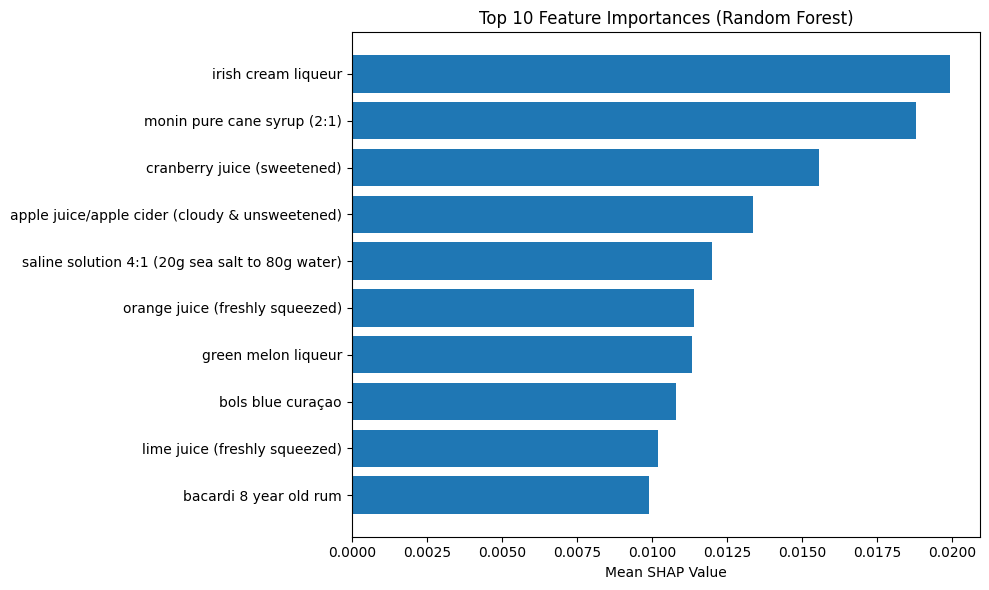

In [18]:
# Plot top 10 features
top_10 = shap_importance.head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_10['feature'][::-1], top_10['importance'][::-1])
plt.xlabel('Mean SHAP Value')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.tight_layout()
plt.savefig('top_10_feature_importance_rf.png')

In [15]:
shap_importance.to_csv('/content/drive/MyDrive/cocktail_dmlr/results/shap_importances_xg.csv', index=False)

# Ridge Regression

In [24]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer

In [23]:
# Use previously selected alphas (tuned earlier)
ridge_alpha = 10  # replace with ridge_model.alpha_
lasso_alpha = 0.00023240763794019127  # replace with lasso_model.alpha_

# Round-to-0.5 helper
def round_to_half(x):
    return np.round(np.array(x) * 2) / 2

Ridge Regression MAE (rounded): 0.2908


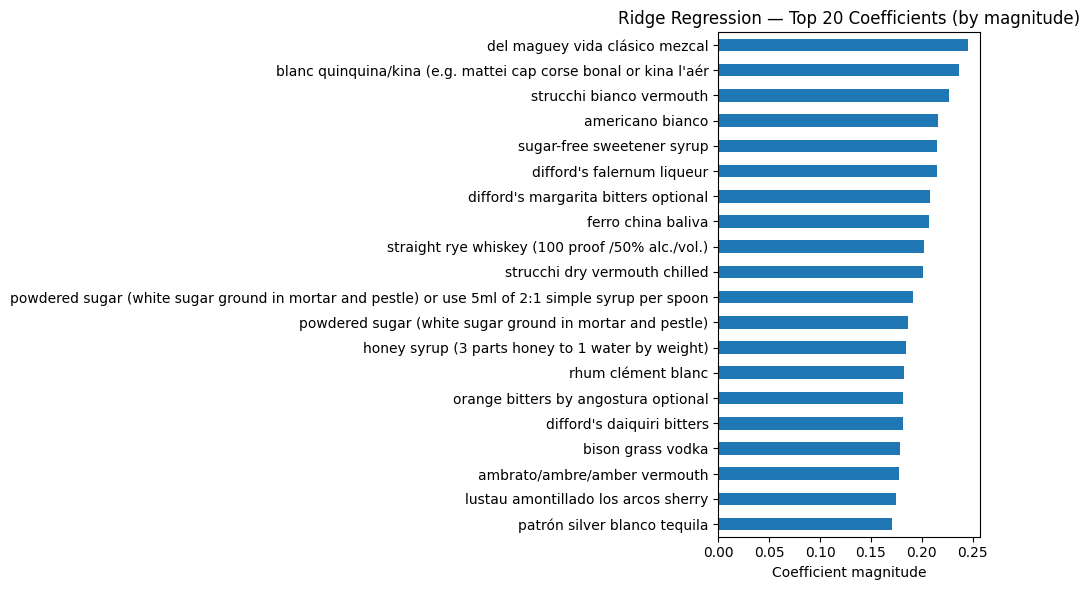

In [26]:
ridge_model = Ridge(alpha=ridge_alpha, random_state=42)
ridge_model.fit(X_train, y_reg_train)

y_pred_ridge = ridge_model.predict(X_test)
mae_ridge = mean_absolute_error(y_reg_test, round_to_half(y_pred_ridge))
print(f"Ridge Regression MAE (rounded): {mae_ridge:.4f}")

# Coefficients
ridge_coefs = pd.Series(ridge_model.coef_, index=X_train.columns).sort_values(ascending=False)
ridge_coefs.to_csv("ridge_coefficients.csv", header=["coefficient"])

# Plot top 20
plt.figure(figsize=(10, 6))
ridge_coefs.abs().head(20).sort_values().plot(kind='barh')
plt.title("Ridge Regression — Top 20 Coefficients (by magnitude)")
plt.xlabel("Coefficient magnitude")
plt.tight_layout()
plt.show()

In [30]:
# Compute SHAP values on the test subset
explainer = shap.Explainer(ridge_model, X_test)
shap_values = explainer(X_test)

# Compute mean absolute SHAP values per feature
shap_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': shap_values.abs.mean(0).values
}).sort_values(by='importance', ascending=False)

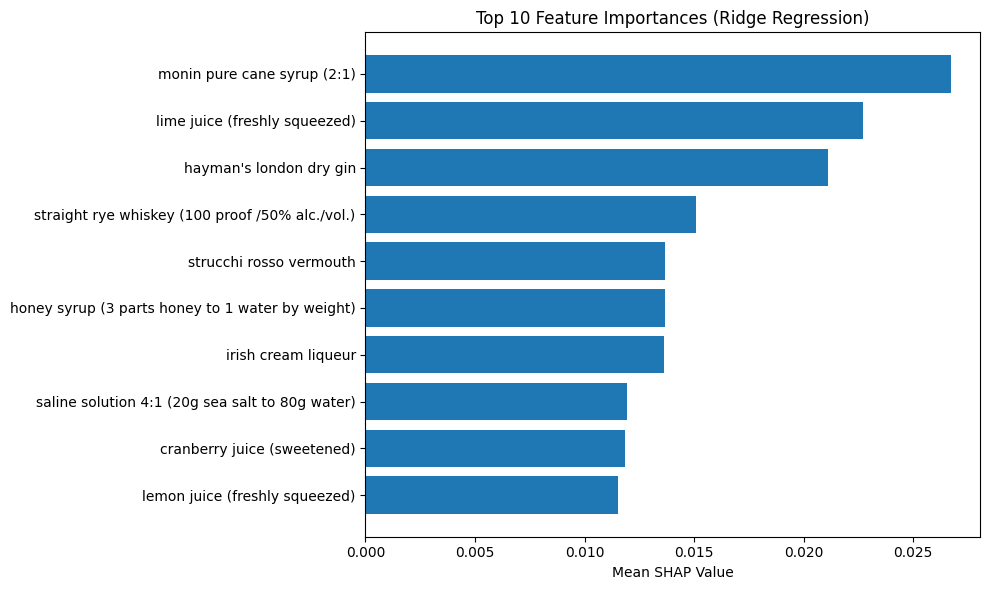

In [31]:
# Plot top 10 features
top_10 = shap_importance.head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_10['feature'][::-1], top_10['importance'][::-1])
plt.xlabel('Mean SHAP Value')
plt.title('Top 10 Feature Importances (Ridge Regression)')
plt.tight_layout()
plt.savefig('top_10_feature_importance_rf.png')

In [32]:
shap_importance.to_csv('/content/drive/MyDrive/cocktail_dmlr/results/shap_importances_ridge.csv', index=False)

# Lasso Regression

Lasso Regression MAE (rounded): 0.2896


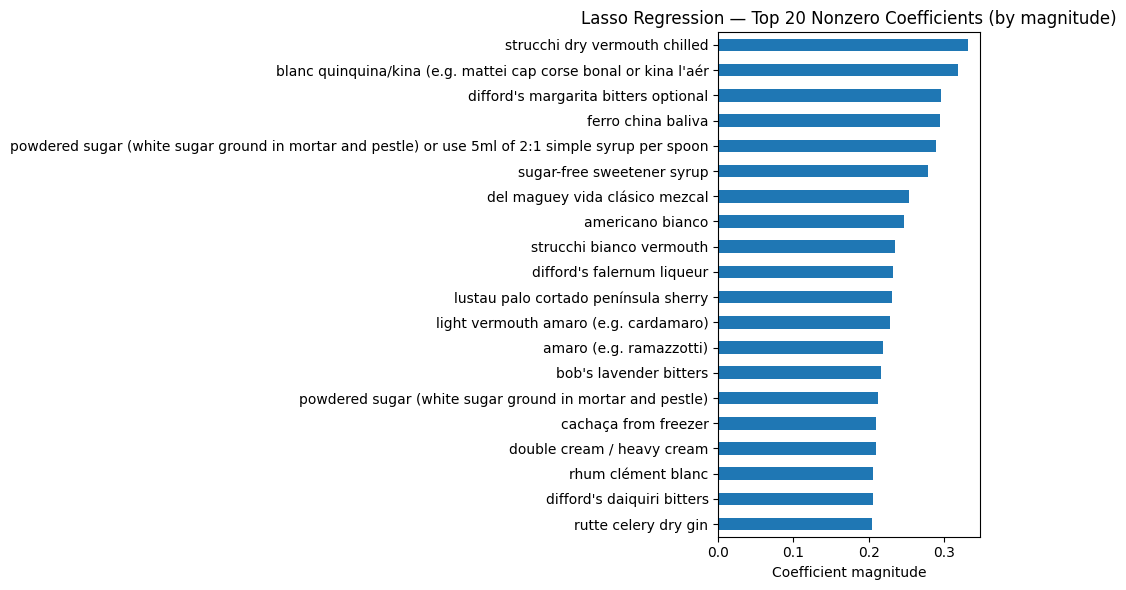

In [34]:
lasso_model = Lasso(alpha=lasso_alpha, random_state=42, max_iter=5000)
lasso_model.fit(X_train, y_reg_train)

y_pred_lasso = lasso_model.predict(X_test)
mae_lasso = mean_absolute_error(y_reg_test, round_to_half(y_pred_lasso))
print(f"Lasso Regression MAE (rounded): {mae_lasso:.4f}")

# Coefficients
lasso_coefs = pd.Series(lasso_model.coef_, index=X_train.columns)
lasso_coefs_nonzero = lasso_coefs[lasso_coefs != 0].sort_values(ascending=False)
lasso_coefs_nonzero.to_csv("lasso_coefficients.csv", header=["coefficient"])

# Plot top 20
plt.figure(figsize=(10, 6))
lasso_coefs_nonzero.abs().head(20).sort_values().plot(kind='barh')
plt.title("Lasso Regression — Top 20 Nonzero Coefficients (by magnitude)")
plt.xlabel("Coefficient magnitude")
plt.tight_layout()
plt.show()

In [35]:
# Compute SHAP values on the test subset
explainer = shap.Explainer(lasso_model, X_test)
shap_values = explainer(X_test)

# Compute mean absolute SHAP values per feature
shap_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': shap_values.abs.mean(0).values
}).sort_values(by='importance', ascending=False)

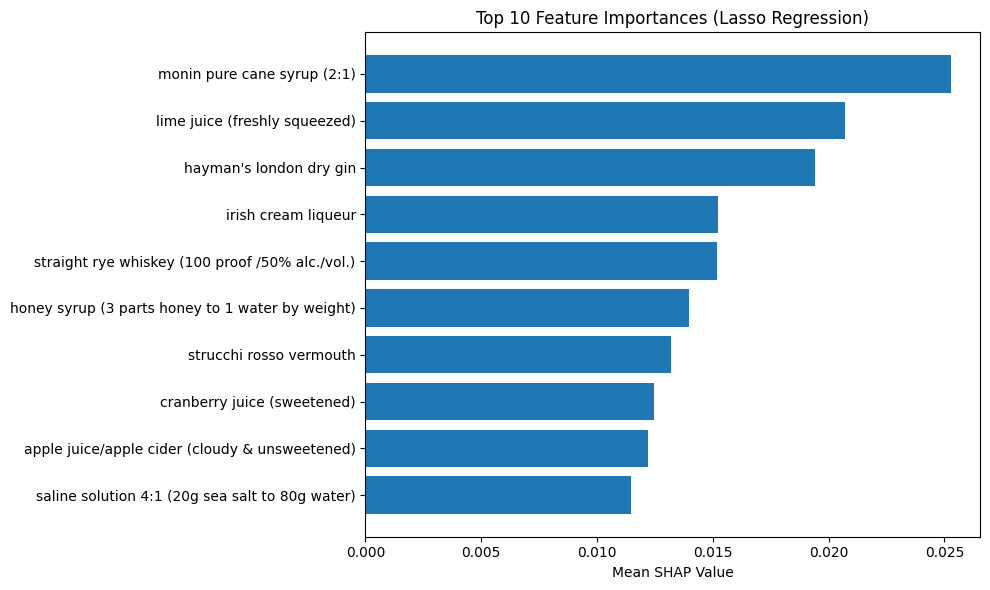

In [36]:
# Plot top 10 features
top_10 = shap_importance.head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_10['feature'][::-1], top_10['importance'][::-1])
plt.xlabel('Mean SHAP Value')
plt.title('Top 10 Feature Importances (Lasso Regression)')
plt.tight_layout()
plt.savefig('top_10_feature_importance_rf.png')